In [1]:
!kaggle datasets download -d xixuhu/office31 --unzip -p /content/

Dataset URL: https://www.kaggle.com/datasets/xixuhu/office31
License(s): unknown
 83% 63.0M/75.9M [00:00<00:00, 164MB/s]
100% 75.9M/75.9M [00:00<00:00, 126MB/s]


In [2]:
!pip install timm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms

# with `vit_base_patch16_224` (debo bhai)

In [ ]:
class ImprovedModel(nn.Module):
    def __init__(self, latent_dim=512, num_classes=65):
        super(ImprovedModel, self).__init__()

        # Use ViT as the backbone encoder
        self.encoder = timm.create_model('vit_base_patch16_224', pretrained=True)

        # Get the feature size from ViT output
        self.encoder_head_dim = self.encoder.head.in_features
        self.encoder.head = nn.Identity()  # Remove the original classification head

        # Latent space projection
        self.fc_latent = nn.Linear(self.encoder_head_dim, latent_dim)

        # Classifier for 65 classes
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, num_classes)
        )

    def forward(self, x):
        # Forward through ViT (feature extraction)
        features = self.encoder(x)  # ViT returns the features

        # Project to latent space
        latent = self.fc_latent(features)

        # Classification head
        output = self.classifier(latent)
        return output, latent

In [ ]:
# Function to train the classifier on the source dataset
def train_classifier(model, dataloader, num_classes=65, n_epochs=10, lr=1e-3, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.CrossEntropyLoss()

    # Scaler for mixed precision
    scaler = GradScaler()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():  # Use mixed precision
                outputs, _ = model(images)  # Model returns both output and latent vectors
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Step the scheduler after each epoch
        scheduler.step()

        # Calculate average loss and accuracy
        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples * 100

        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [ ]:
# Function to evaluate the classifier on the target dataset
def evaluate_classifier(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            with autocast():  # Use mixed precision
                outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples * 100
    print(f'Accuracy on Target Domain: {accuracy:.2f}%')

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bars

# Function to train the classifier on the source dataset with progress bar
def train_classifier(model, dataloader, num_classes=65, n_epochs=10, lr=1e-3, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.CrossEntropyLoss()

    # Scaler for mixed precision
    scaler = GradScaler()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        # Add tqdm progress bar
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{n_epochs}]")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():  # Use mixed precision
                outputs, _ = model(images)  # Model returns both output and latent vectors
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Update tqdm progress bar description with current loss and accuracy
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

        # Step the scheduler after each epoch
        scheduler.step()

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples * 100

        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


# Function to evaluate the classifier on the target dataset with progress bar
def evaluate_classifier(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    correct_predictions = 0
    total_samples = 0

    # Add tqdm progress bar
    progress_bar = tqdm(dataloader, desc="Evaluating")

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            with autocast():  # Use mixed precision
                outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Update tqdm progress bar description with current accuracy
            progress_bar.set_postfix({
                'Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

    accuracy = correct_predictions / total_samples * 100
    print(f'Accuracy on Target Domain: {accuracy:.2f}%')


num_classes = 31
latent_dim = 1024
model = ImprovedModel(latent_dim=latent_dim, num_classes=num_classes)

source_dir = "/content/Office-31/amazon"
target_dir = "/content/Office-31/dslr"


dataset_source = datasets.ImageFolder(root=source_dir, transform=transform_train)
dataset_target = datasets.ImageFolder(root=target_dir, transform=transform_eval)

dataloader_source = DataLoader(dataset_source, batch_size=64, shuffle=True)
dataloader_target = DataLoader(dataset_target, batch_size=64, shuffle=True)

train_classifier(model, dataloader_source, num_classes=num_classes, n_epochs=10, lr=1e-3, weight_decay=1e-4)
evaluate_classifier(model, dataloader_target)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-9-1964a66b7e40>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch [1/10]:   0%|          | 0/45 [00:00<?, ?it/s]<ipython-input-9-1964a66b7e40>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision
Epoch [1/10]: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s, Loss=3.0391, Accuracy=3.66%]


Epoch [1/10], Loss: 3.4673, Accuracy: 3.66%


Epoch [2/10]: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, Loss=3.4297, Accuracy=5.04%]


Epoch [2/10], Loss: 3.3820, Accuracy: 5.04%


Epoch [3/10]: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s, Loss=3.4570, Accuracy=4.97%]


Epoch [3/10], Loss: 3.3577, Accuracy: 4.97%


Epoch [4/10]: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s, Loss=3.5527, Accuracy=5.75%]


Epoch [4/10], Loss: 3.3295, Accuracy: 5.75%


Epoch [5/10]: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s, Loss=3.6992, Accuracy=5.68%]


Epoch [5/10], Loss: 3.3502, Accuracy: 5.68%


Epoch [6/10]: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s, Loss=3.6289, Accuracy=5.32%]


Epoch [6/10], Loss: 3.3484, Accuracy: 5.32%


Epoch [7/10]: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s, Loss=3.5078, Accuracy=7.67%]


Epoch [7/10], Loss: 3.2856, Accuracy: 7.67%


Epoch [8/10]: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s, Loss=3.3457, Accuracy=7.67%]


Epoch [8/10], Loss: 3.2610, Accuracy: 7.67%


Epoch [9/10]: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s, Loss=2.6426, Accuracy=10.90%]


Epoch [9/10], Loss: 3.1682, Accuracy: 10.90%


Epoch [10/10]: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s, Loss=3.4980, Accuracy=11.54%]


Epoch [10/10], Loss: 3.1280, Accuracy: 11.54%


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]<ipython-input-9-1964a66b7e40>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision
Evaluating: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s, Accuracy=3.61%]

Accuracy on Target Domain: 3.61%


# with `DeiT (data-efficient image transformers)`

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

class ImprovedModel(nn.Module):
    def __init__(self, latent_dim=1024, num_classes=31):
        super(ImprovedModel, self).__init__()
        self.encoder = timm.create_model('deit_small_patch16_224', pretrained=True)
        self.encoder_head_dim = self.encoder.head.in_features
        self.encoder.head = nn.Identity()
        self.fc_latent = nn.Linear(self.encoder_head_dim, latent_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        latent = self.fc_latent(features)
        output = self.classifier(latent)
        return output, latent

In [ ]:
def train_classifier(model, dataloader, num_classes=31, n_epochs=10, lr=1e-3, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{n_epochs}]")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples * 100
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
def evaluate_classifier(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc="Evaluating")

    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            progress_bar.set_postfix({
                'Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

    accuracy = correct_predictions / total_samples * 100
    print(f'Accuracy on Target Domain: {accuracy:.2f}%')

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
num_classes = 31
latent_dim = 1024
model = ImprovedModel(latent_dim=latent_dim, num_classes=num_classes)

source_dir = "/content/Office-31/amazon"
target_dir = "/content/Office-31/dslr"

dataset_source = datasets.ImageFolder(root=source_dir, transform=transform_train)
dataset_target = datasets.ImageFolder(root=target_dir, transform=transform_eval)

dataloader_source = DataLoader(dataset_source, batch_size=64, shuffle=True)
dataloader_target = DataLoader(dataset_target, batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
train_classifier(model, dataloader_source, num_classes=num_classes, n_epochs=10, lr=1e-4, weight_decay=1e-4)
evaluate_classifier(model, dataloader_target)

<ipython-input-5-01a17457dd05>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch [1/10]: 100%|██████████| 45/45 [00:52<00:00,  1.16s/it, Loss=2.3020, Accuracy=63.83%]


Epoch [1/10], Loss: 1.9667, Accuracy: 63.83%


Epoch [2/10]: 100%|██████████| 45/45 [00:45<00:00,  1.00s/it, Loss=0.1984, Accuracy=87.04%]


Epoch [2/10], Loss: 0.6053, Accuracy: 87.04%


Epoch [3/10]: 100%|██████████| 45/45 [00:45<00:00,  1.00s/it, Loss=0.0323, Accuracy=93.72%]


Epoch [3/10], Loss: 0.2879, Accuracy: 93.72%


Epoch [4/10]: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, Loss=0.0335, Accuracy=96.84%]


Epoch [4/10], Loss: 0.1558, Accuracy: 96.84%


Epoch [5/10]: 100%|██████████| 45/45 [00:44<00:00,  1.00it/s, Loss=0.0176, Accuracy=98.44%]


Epoch [5/10], Loss: 0.0872, Accuracy: 98.44%


Epoch [6/10]: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, Loss=0.0065, Accuracy=99.08%]


Epoch [6/10], Loss: 0.0588, Accuracy: 99.08%


Epoch [7/10]: 100%|██████████| 45/45 [00:47<00:00,  1.05s/it, Loss=0.0065, Accuracy=99.47%]


Epoch [7/10], Loss: 0.0385, Accuracy: 99.47%


Epoch [8/10]: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it, Loss=0.0054, Accuracy=99.61%]


Epoch [8/10], Loss: 0.0333, Accuracy: 99.61%


Epoch [9/10]: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it, Loss=0.0062, Accuracy=99.65%]


Epoch [9/10], Loss: 0.0239, Accuracy: 99.65%


Epoch [10/10]: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it, Loss=0.0059, Accuracy=99.75%]


Epoch [10/10], Loss: 0.0238, Accuracy: 99.75%


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]<ipython-input-6-8bec55f887bd>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, Accuracy=75.90%]

Accuracy on Target Domain: 75.90%


# Trying out Uncertainty

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

<ipython-input-3-cd06514e63c5>:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch [1/20]:   0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-3-cd06514e63c5>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1/20]: 100%|██████████| 12/12 [01:55<00:00,  9.63s/it, Loss=5.2855, Accuracy=32.52%]


Epoch [1/20], Loss: 2.7754, Accuracy: 32.52%


Epoch [2/20]: 100%|██████████| 12/12 [01:55<00:00,  9.63s/it, Loss=0.5902, Accuracy=59.71%]


Epoch [2/20], Loss: 1.3921, Accuracy: 59.71%


Epoch [3/20]: 100%|██████████| 12/12 [01:54<00:00,  9.58s/it, Loss=0.0249, Accuracy=65.35%]


Epoch [3/20], Loss: 1.1625, Accuracy: 65.35%


Epoch [4/20]: 100%|██████████| 12/12 [01:54<00:00,  9.56s/it, Loss=0.0067, Accuracy=81.04%]


Epoch [4/20], Loss: 0.6213, Accuracy: 81.04%


Epoch [5/20]: 100%|██████████| 12/12 [01:55<00:00,  9.61s/it, Loss=0.0028, Accuracy=90.88%]


Epoch [5/20], Loss: 0.3024, Accuracy: 90.88%


Epoch [6/20]: 100%|██████████| 12/12 [01:53<00:00,  9.43s/it, Loss=0.0024, Accuracy=95.49%]


Epoch [6/20], Loss: 0.1493, Accuracy: 95.49%


Epoch [7/20]: 100%|██████████| 12/12 [01:52<00:00,  9.37s/it, Loss=0.0078, Accuracy=98.23%]


Epoch [7/20], Loss: 0.0681, Accuracy: 98.23%


Epoch [8/20]: 100%|██████████| 12/12 [01:53<00:00,  9.46s/it, Loss=0.0076, Accuracy=98.86%]


Epoch [8/20], Loss: 0.0442, Accuracy: 98.86%


Epoch [9/20]: 100%|██████████| 12/12 [01:54<00:00,  9.51s/it, Loss=0.0022, Accuracy=99.01%]


Epoch [9/20], Loss: 0.0329, Accuracy: 99.01%


Epoch [10/20]: 100%|██████████| 12/12 [01:53<00:00,  9.45s/it, Loss=0.0015, Accuracy=99.29%]


Epoch [10/20], Loss: 0.0291, Accuracy: 99.29%


Epoch [11/20]: 100%|██████████| 12/12 [01:52<00:00,  9.39s/it, Loss=0.0001, Accuracy=99.25%]


Epoch [11/20], Loss: 0.0217, Accuracy: 99.25%


Epoch [12/20]: 100%|██████████| 12/12 [01:51<00:00,  9.27s/it, Loss=0.0015, Accuracy=99.75%]


Epoch [12/20], Loss: 0.0143, Accuracy: 99.75%


Epoch [13/20]: 100%|██████████| 12/12 [01:52<00:00,  9.40s/it, Loss=0.0020, Accuracy=99.82%]


Epoch [13/20], Loss: 0.0089, Accuracy: 99.82%


Epoch [14/20]: 100%|██████████| 12/12 [01:52<00:00,  9.34s/it, Loss=0.0001, Accuracy=99.86%]


Epoch [14/20], Loss: 0.0094, Accuracy: 99.86%


Epoch [15/20]: 100%|██████████| 12/12 [01:52<00:00,  9.36s/it, Loss=0.0040, Accuracy=99.89%]


Epoch [15/20], Loss: 0.0060, Accuracy: 99.89%


Epoch [16/20]: 100%|██████████| 12/12 [01:54<00:00,  9.56s/it, Loss=0.0127, Accuracy=99.86%]


Epoch [16/20], Loss: 0.0071, Accuracy: 99.86%


Epoch [17/20]: 100%|██████████| 12/12 [01:53<00:00,  9.44s/it, Loss=0.0001, Accuracy=99.89%]


Epoch [17/20], Loss: 0.0047, Accuracy: 99.89%


Epoch [18/20]: 100%|██████████| 12/12 [01:53<00:00,  9.49s/it, Loss=0.0005, Accuracy=99.89%]


Epoch [18/20], Loss: 0.0050, Accuracy: 99.89%


Epoch [19/20]: 100%|██████████| 12/12 [01:54<00:00,  9.51s/it, Loss=0.0014, Accuracy=99.96%]


Epoch [19/20], Loss: 0.0048, Accuracy: 99.96%


Epoch [20/20]: 100%|██████████| 12/12 [01:53<00:00,  9.47s/it, Loss=0.0063, Accuracy=99.75%]


Epoch [20/20], Loss: 0.0095, Accuracy: 99.75%


Evaluating with MC Dropout:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-3-cd06514e63c5>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating with MC Dropout: 100%|██████████| 2/2 [02:38<00:00, 79.18s/it]


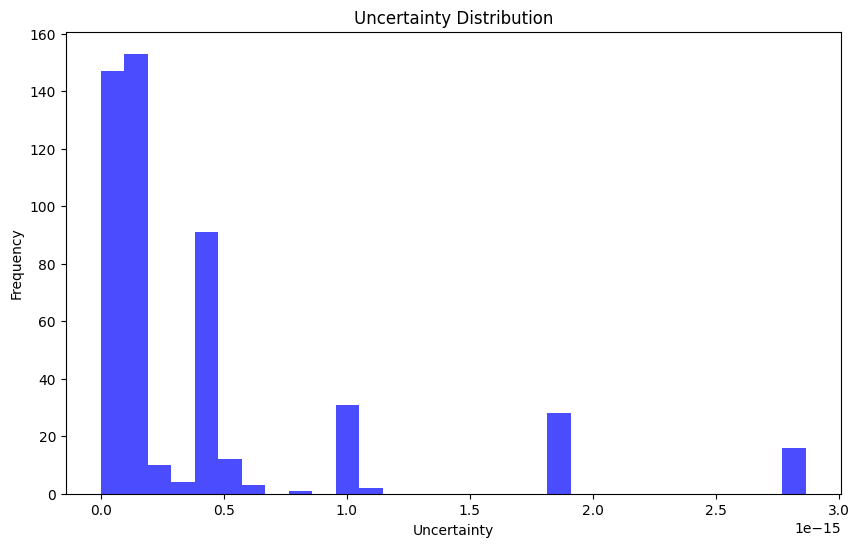

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class ImprovedModel(nn.Module):
    def __init__(self, latent_dim=1024, num_classes=31):
        super(ImprovedModel, self).__init__()
        self.encoder = timm.create_model('deit_small_patch16_224', pretrained=True)
        self.encoder_head_dim = self.encoder.head.in_features
        self.encoder.head = nn.Identity()
        self.fc_latent = nn.Linear(self.encoder_head_dim, latent_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        latent = self.fc_latent(features)
        output = self.classifier(latent)
        return output, latent

def train_classifier(model, dataloader, num_classes=31, n_epochs=100, lr=1e-3, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{n_epochs}]")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs, _ = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples * 100

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return epoch_losses, epoch_accuracies

def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def mc_dropout_inference(model, dataloader, n_samples=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    enable_dropout(model)
    model.eval()

    all_predictions = []
    uncertainty_scores = []

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Evaluating with MC Dropout"):
            images = images.to(device)
            mc_predictions = []

            for _ in range(n_samples):
                with autocast():
                    outputs, _ = model(images)
                    probabilities = nn.functional.softmax(outputs, dim=1)
                    mc_predictions.append(probabilities.cpu().numpy())

            mc_predictions = np.stack(mc_predictions, axis=0)
            mean_predictions = np.mean(mc_predictions, axis=0)
            uncertainty = np.var(mc_predictions, axis=0).mean(axis=1)

            all_predictions.append(mean_predictions)
            uncertainty_scores.append(uncertainty)

    return np.vstack(all_predictions), np.hstack(uncertainty_scores)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

num_classes = 31
latent_dim = 1024
model = ImprovedModel(latent_dim=latent_dim, num_classes=num_classes)

source_dir = "/content/Office-31/amazon"
target_dir = "/content/Office-31/dslr"

dataset_source = datasets.ImageFolder(root=source_dir, transform=transform_train)
dataset_target = datasets.ImageFolder(root=target_dir, transform=transform_eval)

dataloader_source = DataLoader(dataset_source, batch_size=256, shuffle=True)
dataloader_target = DataLoader(dataset_target, batch_size=256, shuffle=True)

train_losses, train_accuracies = train_classifier(model, dataloader_source, num_classes=num_classes, n_epochs=20, lr=1e-3, weight_decay=1e-4)

# Monte Carlo Dropout for uncertainty estimation
predictions, uncertainties = mc_dropout_inference(model, dataloader_target, n_samples=20)

plt.figure(figsize=(10, 6))
plt.hist(uncertainties, bins=30, color='blue', alpha=0.7)
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.show()

In [4]:
def mc_dropout_domain_adaptation_accuracy(model, dataloader, n_samples=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    enable_dropout(model)
    model.eval()

    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc="Evaluating with MC Dropout for Domain Adaptation")

    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            mc_predictions = []

            for _ in range(n_samples):
                with autocast():
                    outputs, _ = model(images)
                    probabilities = nn.functional.softmax(outputs, dim=1)
                    mc_predictions.append(probabilities.cpu().numpy())

            mc_predictions = np.stack(mc_predictions, axis=0)
            mean_predictions = np.mean(mc_predictions, axis=0)  # Take mean of predictions
            final_predictions = np.argmax(mean_predictions, axis=1)  # Get the most probable class

            correct_predictions += (final_predictions == labels.cpu().numpy()).sum()
            total_samples += labels.size(0)

            progress_bar.set_postfix({
                'Domain Adaptation Accuracy': f'{(correct_predictions / total_samples * 100):.2f}%'
            })

    accuracy = correct_predictions / total_samples * 100
    return accuracy

domain_adaptation_accuracy = mc_dropout_domain_adaptation_accuracy(model, dataloader_target, n_samples=20)


Evaluating with MC Dropout for Domain Adaptation:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-4-2df938068179>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating with MC Dropout for Domain Adaptation: 100%|██████████| 2/2 [02:39<00:00, 79.59s/it, Domain Adaptation Accuracy=63.65%]


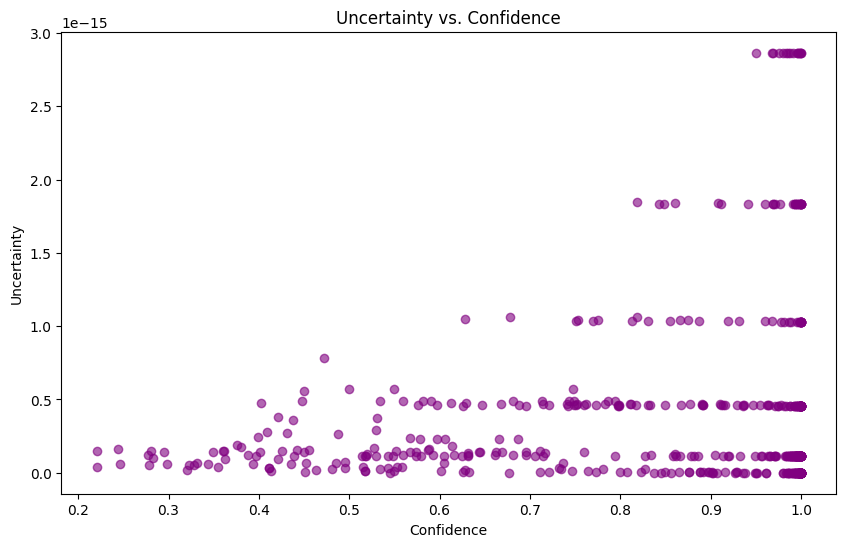

In [5]:
def plot_uncertainty_vs_confidence(predictions, uncertainties):
    confidences = np.max(predictions, axis=1)  # the maximum probability for each prediction (confidence)

    plt.figure(figsize=(10, 6))
    plt.scatter(confidences, uncertainties, alpha=0.6, color='purple')
    plt.title('Uncertainty vs. Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Uncertainty')
    plt.show()

plot_uncertainty_vs_confidence(predictions, uncertainties)